<a href="https://colab.research.google.com/github/cha-suyeon/SAM/blob/main/notebooks/automatic_mask_generator_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [3]:
using_colab = True

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-xd8kz3xt
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-xd8kz3xt
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=2d0d03c0e06aabe9e0294da643178b322049c716e94a050a8cb8b0b699209d00
  Stored in directory: /tmp/pip-ephem-wheel-cache-e54jdqx1/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-02-04 06:30:30--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

## Set-up

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [7]:
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

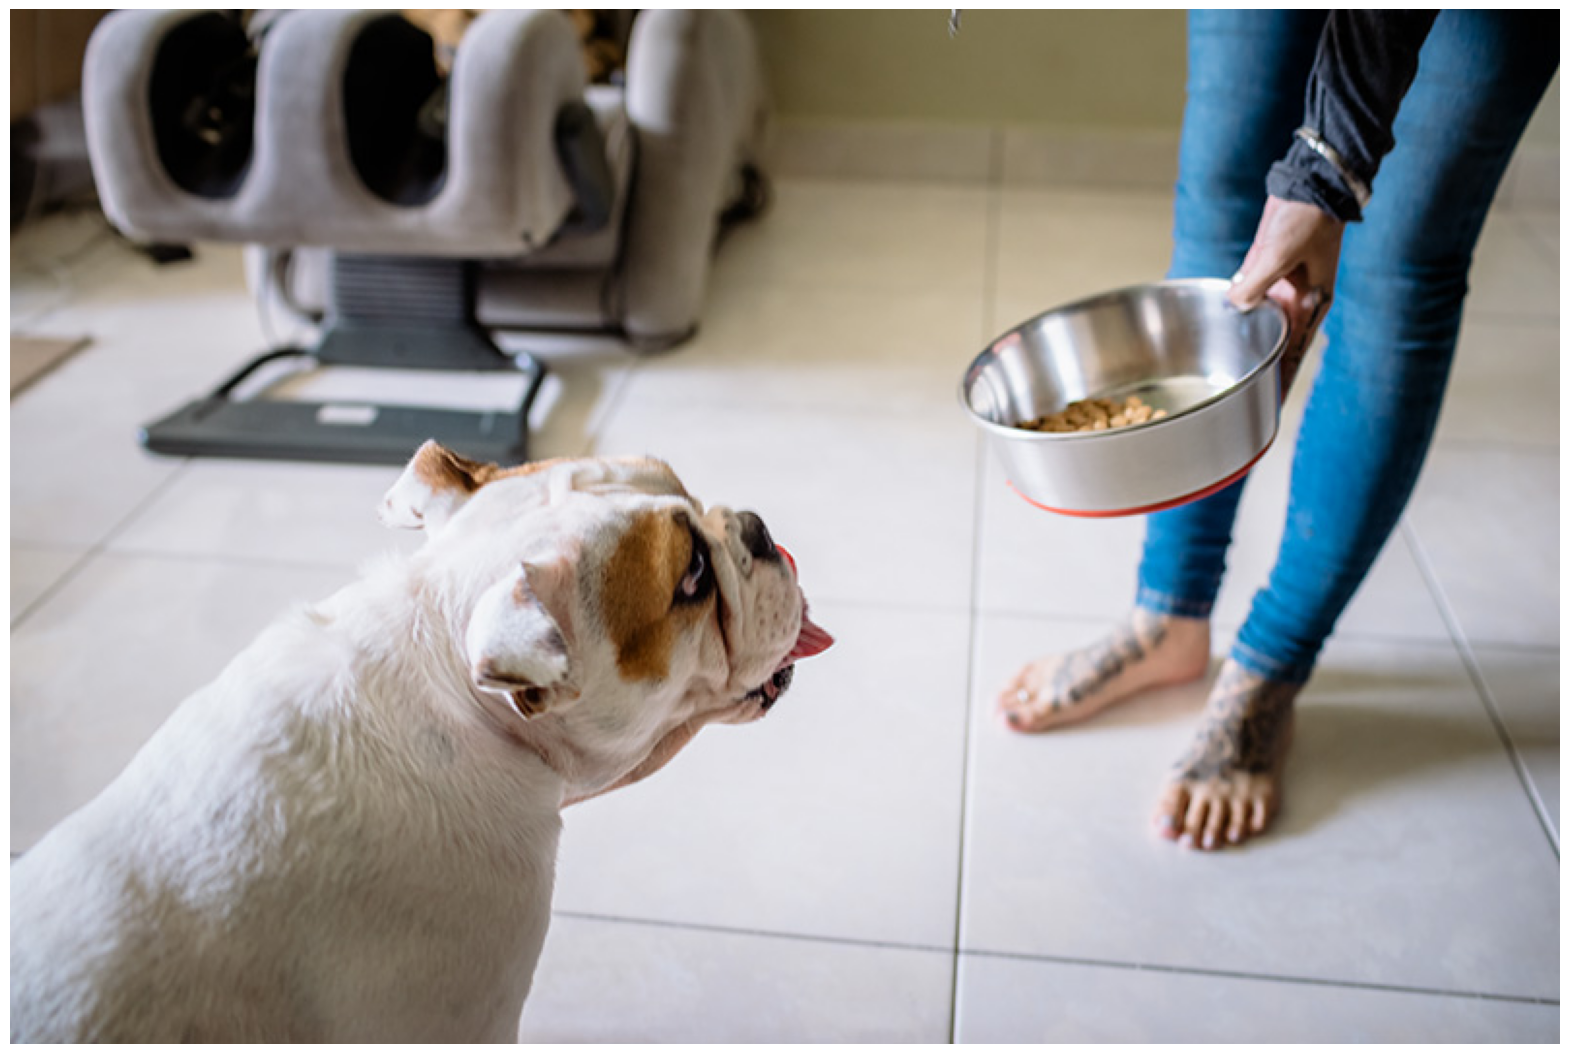

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [9]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


To generate masks, just run `generate` on an image.

In [10]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [11]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

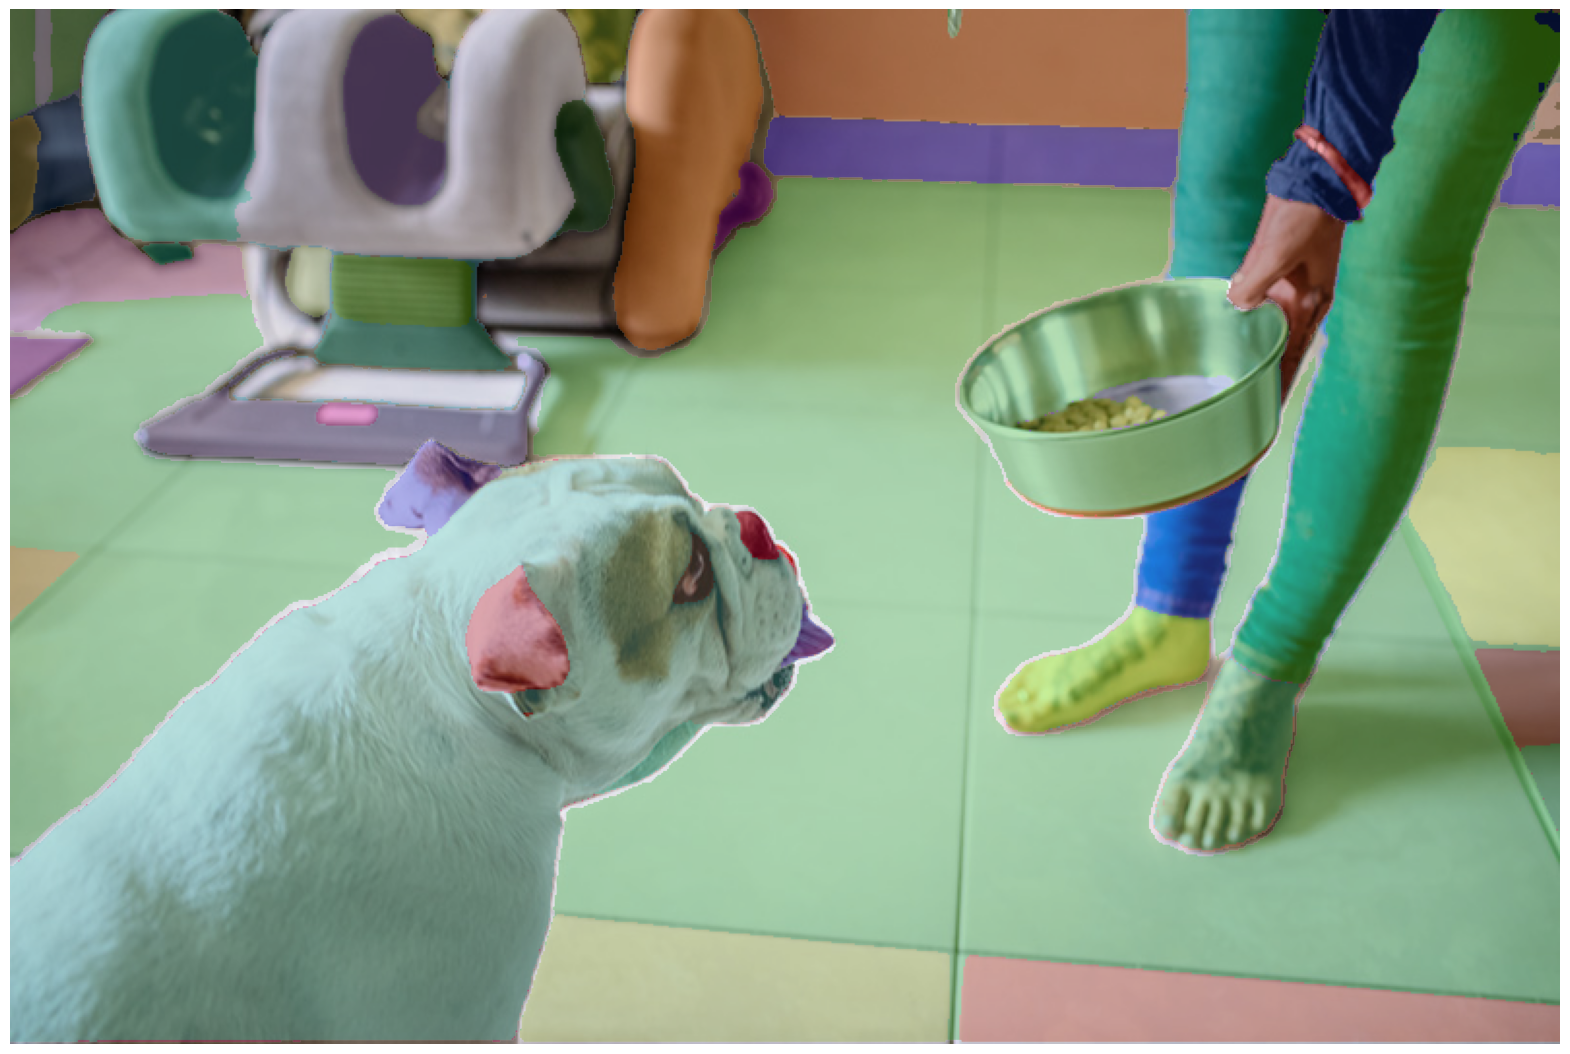

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [13]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [14]:
masks2 = mask_generator_2.generate(image)

In [15]:
len(masks2)

90

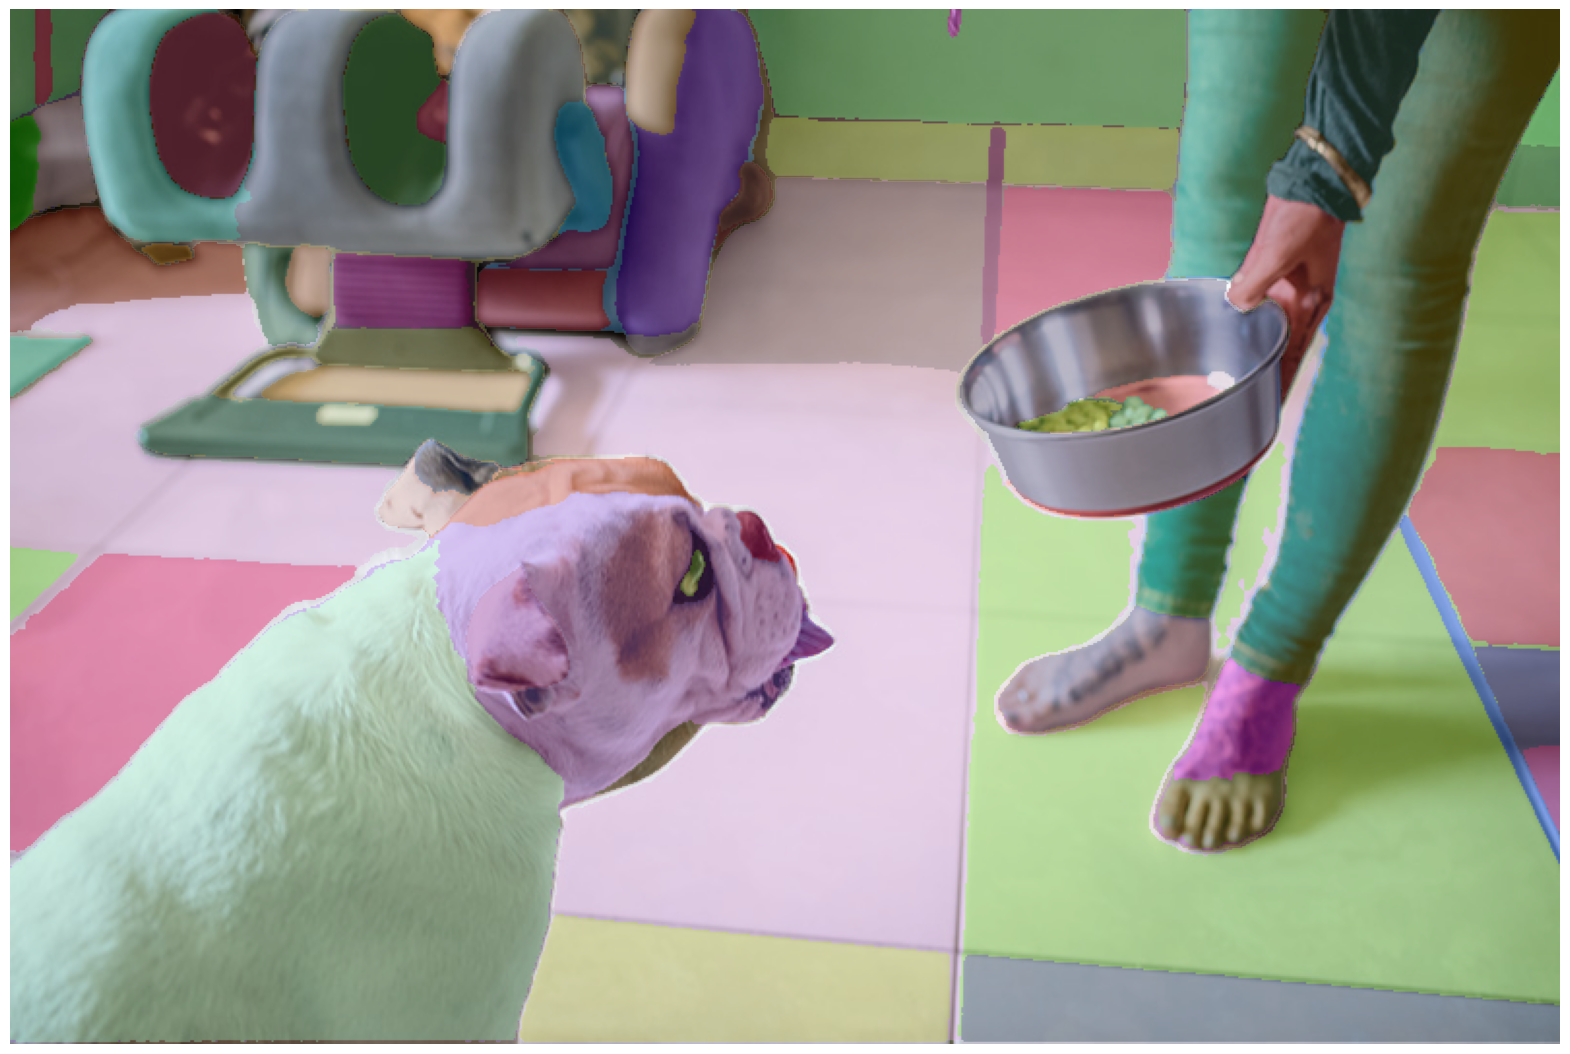

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

### Sample Image test

In [17]:
image = cv2.imread('map.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

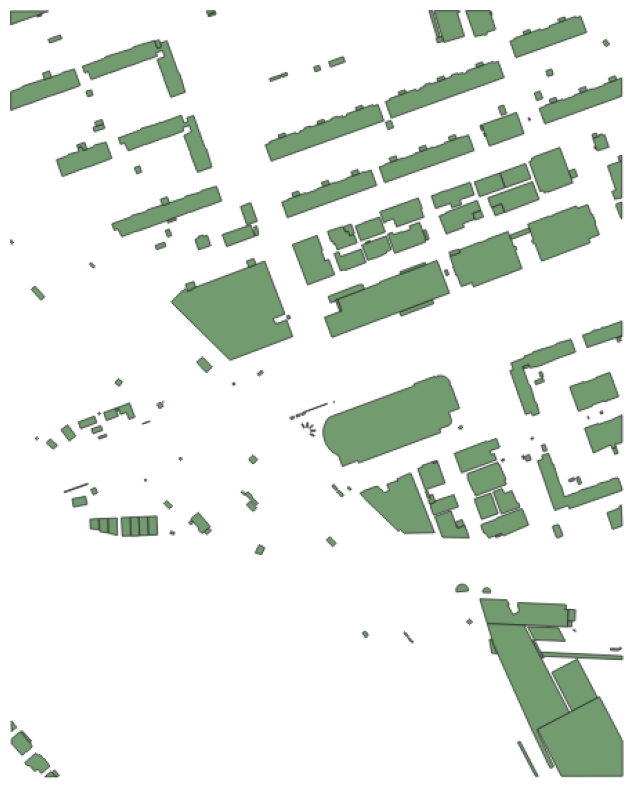

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [19]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [20]:
masks = mask_generator.generate(image)

In [21]:
print(len(masks))
print(masks[0].keys())

124
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


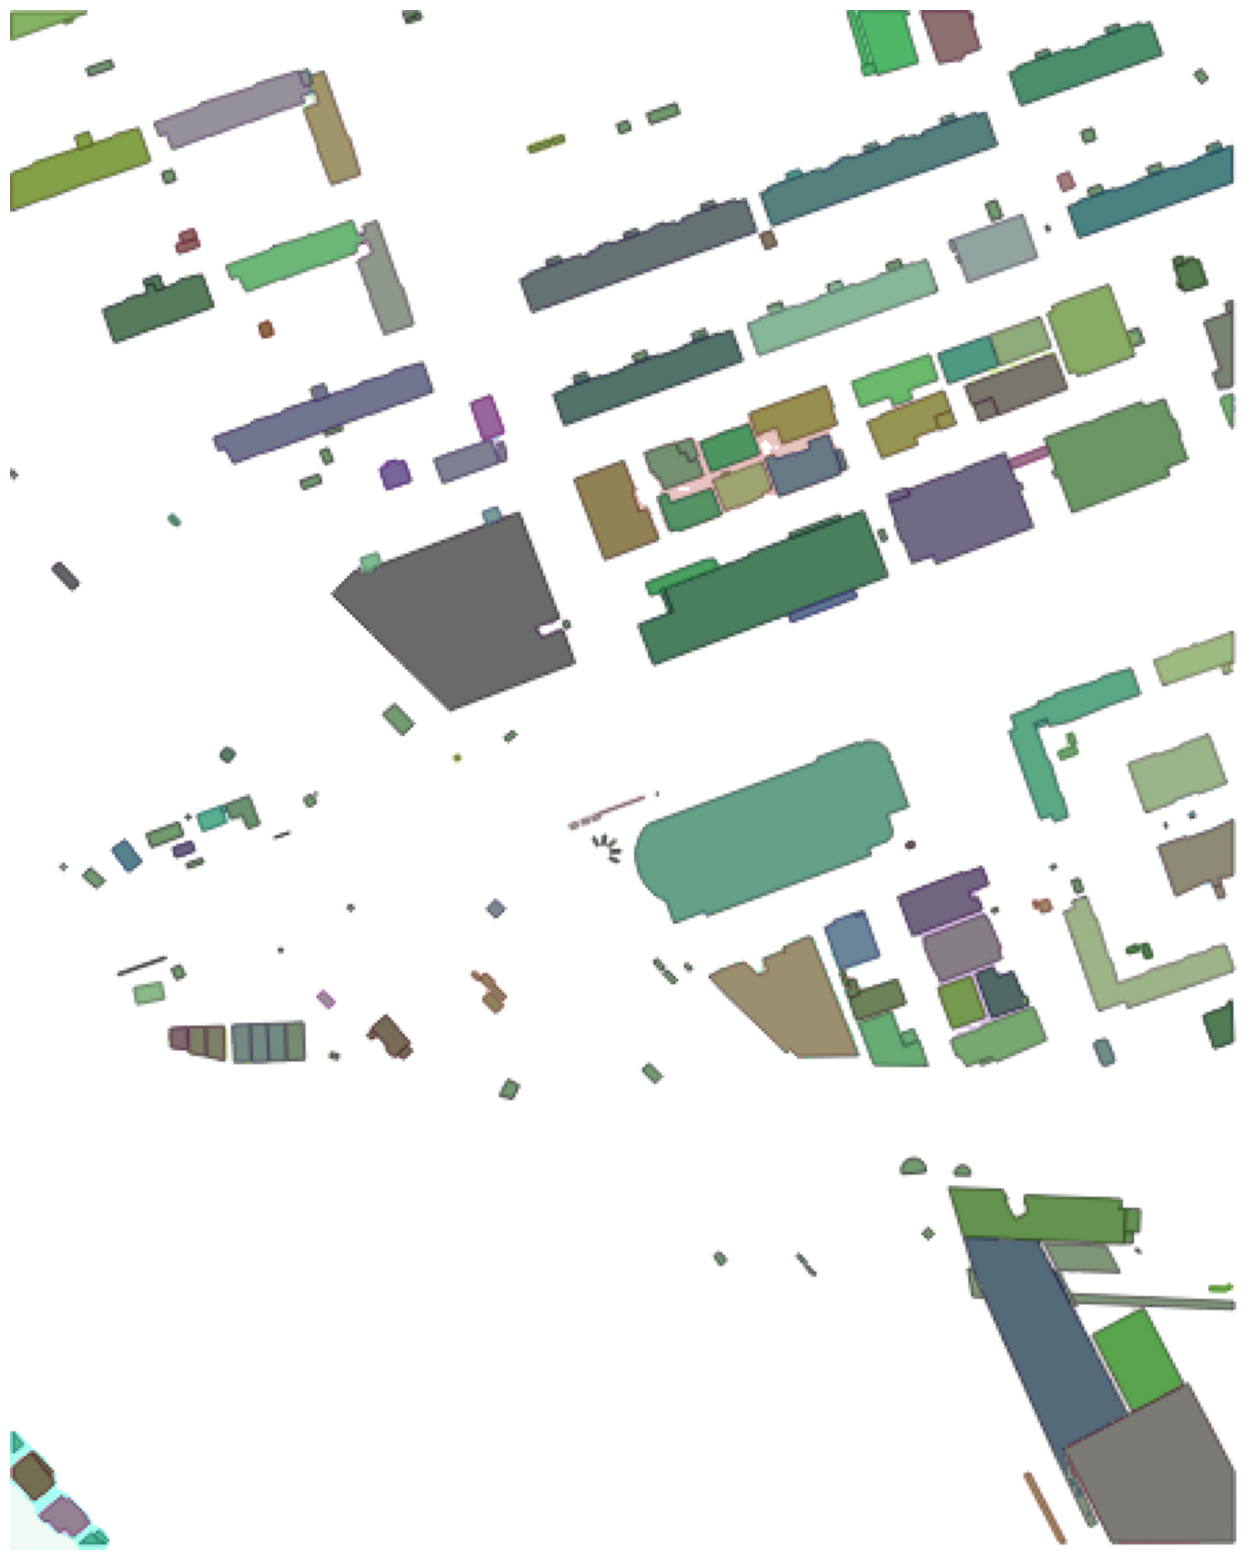

In [22]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

### Automatic mask generation options

In [23]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [24]:
masks2 = mask_generator_2.generate(image)

In [25]:
len(masks2)

145

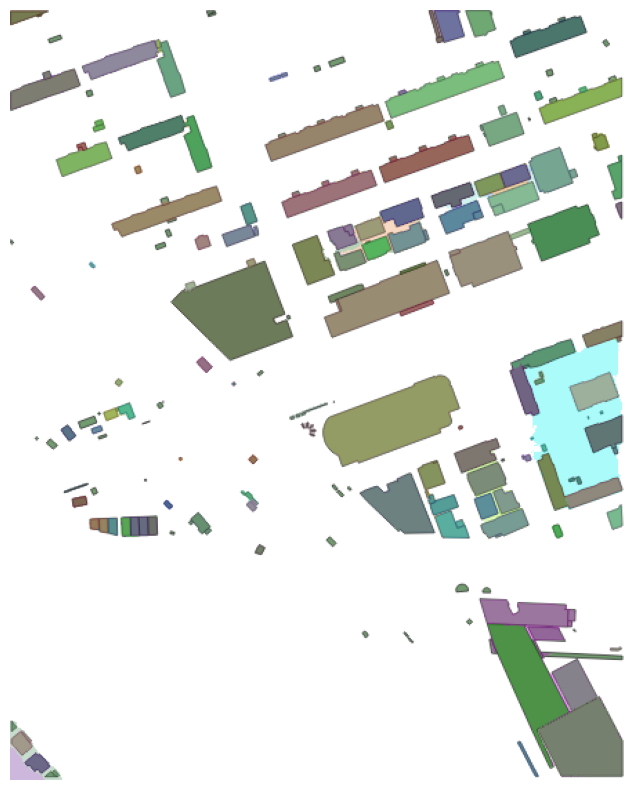

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

### 매개변수 값
- `points_per_side`:	이미지 위에 포인트를 얼마나 촘촘하게 찍을지 결정	값 증가 (ex: 64)	값 감소 (ex: 16)
- `crop_n_layers`:	마스크 예측을 위해 크롭을 몇 단계로 할지 결정	값 증가 (2 이상)	값 감소 (0)
- `crop_n_points_downscale_factor`:	크롭된 이미지 내에서 포인트 밀도를 조정	값 감소 (1)	값 증가 (3)
- `min_mask_region_area`:	최소 감지 영역 크기 (픽셀 단위)	값 감소 (50)	값 증가 (500)
- `stability_score_thresh`:	마스크의 안정성 임계값	값 감소 (0.85)	값 증가 (0.95)

객체를 더 크게 감지하기 위해 수정

- points_per_side: 줄이기 (16~24)
- crop_n_layers: 줄이기 (0~1)
- crop_n_points_downscale_factor: 늘리기 (3~4)
- min_mask_region_area: 늘리기 (300~500)
- stability_score_thresh: 높이기 (0.95)

In [37]:
mask_generator_large_objects = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=15,  # 포인트 밀도 줄이기
    pred_iou_thresh=0.6,
    stability_score_thresh=0.95,  # 더 안정적인 마스크만 선택
    crop_n_layers=0,  # 크롭 사용 안 함
    crop_n_points_downscale_factor=3,  # 크롭된 영역에서 포인트 감소
    min_mask_region_area=500,  # 작은 마스크 제거
)

In [38]:
masks3 = mask_generator_large_objects.generate(image)

In [39]:
len(masks3)

57

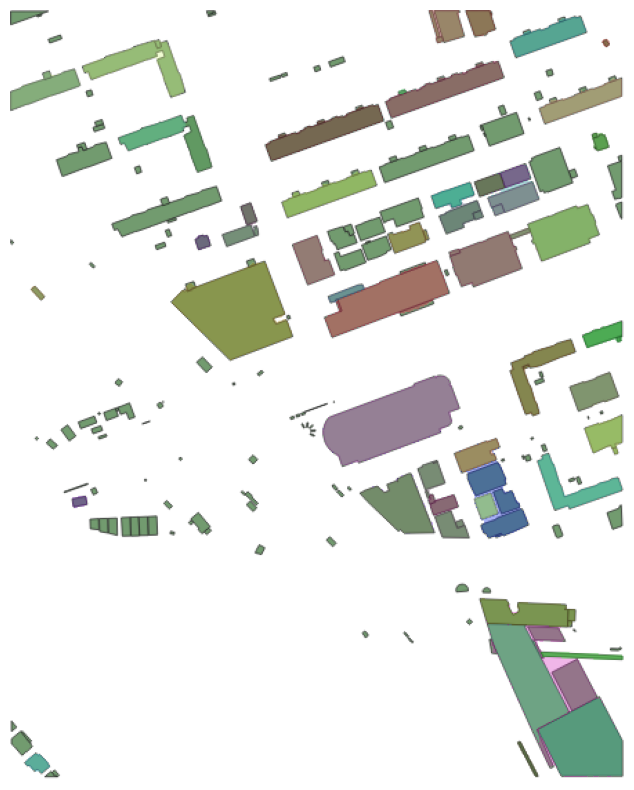

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks3)
plt.axis('off')
plt.show()

56


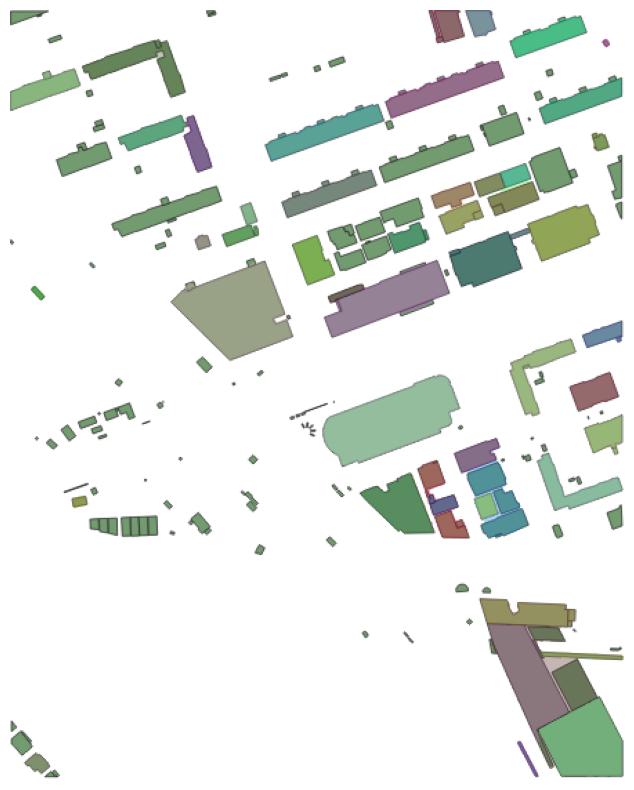

In [41]:
mask_generator_large_objects = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=15,  # 포인트 밀도 줄이기
    pred_iou_thresh=0.85,
    stability_score_thresh=0.95,  # 더 안정적인 마스크만 선택
    crop_n_layers=0,  # 크롭 사용 안 함
    crop_n_points_downscale_factor=3,  # 크롭된 영역에서 포인트 감소
    min_mask_region_area=500,  # 작은 마스크 제거
)

masks3 = mask_generator_large_objects.generate(image)

print(len(masks3))

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks3)
plt.axis('off')
plt.show()

57


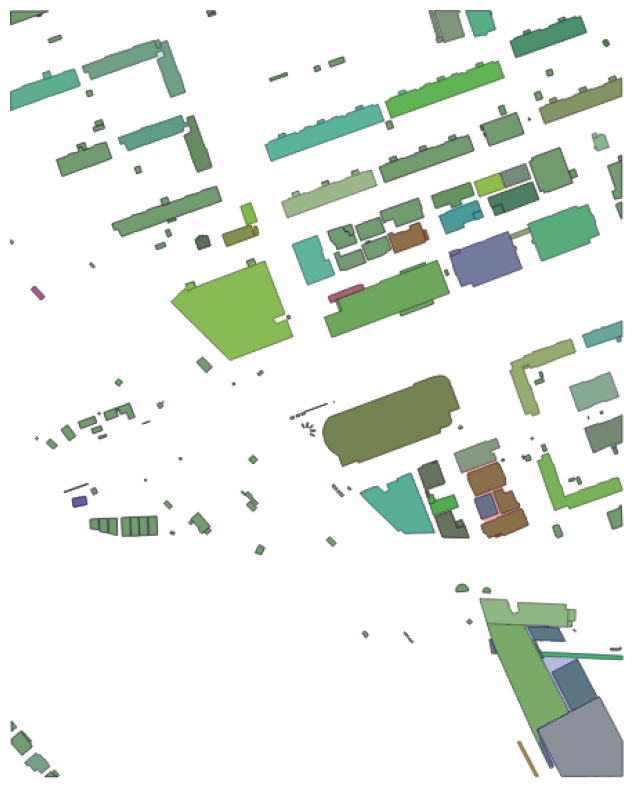

In [43]:
mask_generator_large_objects = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=15,  # 포인트 밀도 줄이기
    pred_iou_thresh=0.4,
    stability_score_thresh=0.95,  # 더 안정적인 마스크만 선택
    crop_n_layers=0,  # 크롭 사용 안 함
    crop_n_points_downscale_factor=3,  # 크롭된 영역에서 포인트 감소
    min_mask_region_area=500,  # 작은 마스크 제거
)

masks3 = mask_generator_large_objects.generate(image)

print(len(masks3))

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks3)
plt.axis('off')
plt.show()

16


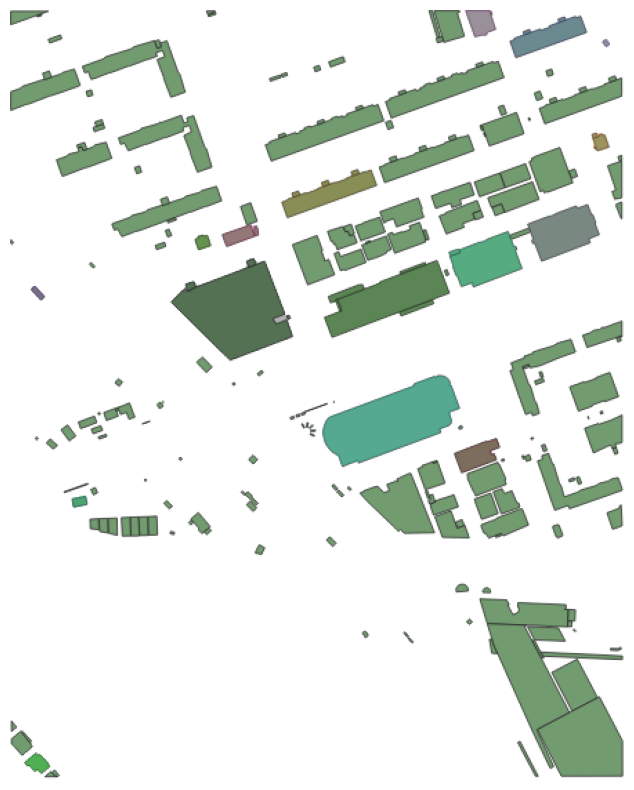

In [48]:
mask_generator_large_objects = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,  # 포인트 밀도 줄이기
    pred_iou_thresh=0.85,
    stability_score_thresh=0.99,  # 더 안정적인 마스크만 선택
    crop_n_layers=0,  # 크롭 사용 안 함
    crop_n_points_downscale_factor=10,  # 크롭된 영역에서 포인트 감소
    min_mask_region_area=300,  # 작은 마스크 제거
)

masks3 = mask_generator_large_objects.generate(image)

print(len(masks3))

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks3)
plt.axis('off')
plt.show()

- 매개변수 하나씩 다 테스트 해보았을 때, 가장 큰 영향을 끼치는 매개변수는 `stability_score_thresh`인 것 같음

37


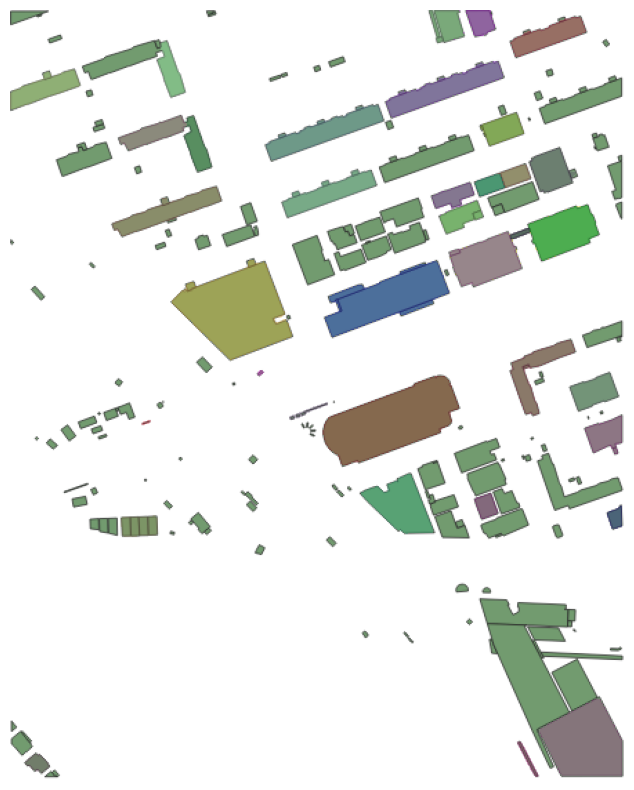

In [50]:
mask_generator_large_objects = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,  # 포인트 밀도 줄이기
    pred_iou_thresh=0.85,
    stability_score_thresh=0.98,  # 더 안정적인 마스크만 선택
    crop_n_layers=0,  # 크롭 사용 안 함
    crop_n_points_downscale_factor=10,  # 크롭된 영역에서 포인트 감소
    min_mask_region_area=300,  # 작은 마스크 제거
)

masks3 = mask_generator_large_objects.generate(image)

print(len(masks3))

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks3)
plt.axis('off')
plt.show()

- 문제점: 작고 다닥다닥 붙어 있는 건물들은 다 합쳐짐. 모든 것을 다 아우르는 방법은 없다.